# Table of Contents

1. [Feature Classification](#feat)
2. [Functions](#Functions)
3. [Quantatative Features](#quan)               
    3.1 [Cleaning](#quan_clean)                 
    3.2 [Modeling (Linear Regression)](#quan_model)
4. [Categorical Features](#cat)   
    4.1 [Cleaning](#cat_clean)                   
    4.2 [Cleaning (NA values)](#cat_clean_NA)                       
    4.3 [Get Dummy Variables (Categorical Features Only)](#cat_dummy)                    
    4.4 [Modeling (Linear Regression)](#cat_model)  
5. [Feature Engineering (Get Interaction Terms)](#feat_eng) 
6. [Final Modeling (Lasso)](#fin)                    
    6.1 [Outlier Handling](#outlier)   
7. [Final Modeling (Linear Regression)](#fin_reg)   
8. [Final Modeling (Ridge)](#fin_ridge)              
    8.1 [Kaggle Submission](#kaggle)               
9. [Tuning (Analysis Using Log Scaled Target)](#tuning)                                  
    9.1. [Modeling (with Log scaled target / Ridge))](#tuning_model)       


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn import metrics

%matplotlib inline

In [2]:
# Read in train data

df = pd.read_csv('./datasets/train.csv')

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


<a id='feat'></a>
## Features Classification

In [4]:
# type_df: dictionary of column's types
type_df = pd.DataFrame(df.dtypes, columns= {'type':0})

# numeric_cols: list of column names with numeric type (int, float)
numeric_cols = list(type_df.loc[(type_df['type']== type(1))|(type_df['type']== type(1.1)), :].index)

# quantatative_cols: list of column names with quantatative data type
quantatative_cols = numeric_cols[3:5]+numeric_cols[9:26]+numeric_cols[27:36]+numeric_cols[38:]

# categorical_cols: list of numerical columns that are categorical
categorical_cols = [numeric_cols[2]] + numeric_cols[5:9] + [numeric_cols[26]] + numeric_cols[36:38]

# non-numeric cols:
non_numeric_cols = list(type_df.loc[(type_df['type']== type_df.loc[ 'MS Zoning' , :][0] ), :].index)

## Functions

In [5]:
def high_corr_cols(cols, dataframe, n = 0.5, p = False):
    
    """
    Return columns of feature with absolute value of correlation to the target higher than n.
    
    Parameters:
        - cols: list/ Names of the column from df
        - n: float/ Correlation to the target
        - df: dataframe/ Dataframe with the target name 'SalePrice' and its features.
        - p: boolean/ Print correlation table with features with its correaltion to the target higher than n.
    """
    
    corr_df = dataframe.loc[:,cols].corr()[['SalePrice']]
    high_corrs = corr_df.loc[abs(corr_df['SalePrice']) >= n , :]
    if p == True:
        print(high_corrs)

    high_corr_cols = list(high_corrs.index)
    return high_corr_cols

In [6]:
def score_calc(test_df):
    
    """
    Return dataframe of 'cv_score', 'train_score', 'test_score' 
    from the Linear Regression fit of features(X) and target(y) in 'test_df'
    
        - 5 trials are performed with different random_state values 
            and the mean of each scores from the trials is caculated.
    
    - Parameters:
        - test_df: dataframe /Dataframe with the target name 'SalePrice' and its features
    """
    
    rs_list = [42, 112, 23, 121, 48]

    X = test_df.drop('SalePrice', axis = 1)
    y = test_df.loc[:, 'SalePrice']
    
    emp_dict = {'cv_score': 0, 'train_score': 0, 'test_score':0, 'num_features': 0}
    out_df = pd.DataFrame(data= list(emp_dict.items()), columns = ['score','to_drop'])
    
    for rs in rs_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

        lr = LinearRegression()
        lr.fit(X_train, y_train)

        score_dict = {'cv_score': cross_val_score(lr, X_train, y_train, cv = 5).mean(), 
                      'train_score': lr.score(X_train, y_train),
                      'test_score' :lr.score(X_test, y_test),
                      'num_features': 0}

        score_df = pd.DataFrame(data = list(score_dict.items()), columns = ['score', f'rs={rs}'])
        
        out_df = pd.merge(out_df, score_df, on = 'score')
    
    out_df = out_df.drop('to_drop', axis = 1)
    out_df['mean'] = out_df.mean(axis=1)
    
    return out_df

In [7]:
def opt_n(cols, dataframe , corr_start = 0.1, corr_end = 0.7, corr_step = 0.025):
    
    """
    Return the mean of 'cv_score', 'train_score', 'test_score', 'num_features'
        from 5 trials with different random state values 
        in the Linear Regression fit of features(X) and target(y) in 'test_df' 
        with different correlation threshold in the range of 'corr_start' to 'corr_end'.
    
    Parameters:
        - cols: list/ Name of columns of feature and target in a dataframe 'df'
        - df: dataframe/ Dataframe with features and target (default: df)
        - corr_start: float/ correlation minimum
        - corr_end: float/ correlation max
        - corr_step: flaot/ correlation step size
    
    """
    
    emp_dict = {'cv_score': 0, 'train_score': 0, 'test_score':0, 'num_features': 0}
    out_df = pd.DataFrame(data= list(emp_dict.items()), columns = ['score','to_drop'])
    
    corrs = np.arange(corr_start, corr_end, corr_step)
    for corr in corrs:
        test_df = dataframe[high_corr_cols(cols = cols, dataframe = dataframe, n = corr)].dropna()
        score_df = score_calc(test_df)
        score_df.loc[score_df['score'] == 'num_features', 'mean'] = \
        int(len(high_corr_cols(cols = cols, dataframe = dataframe, n = corr)))
        score_df = score_df.rename({'mean': f'{round(corr,3)}'}, axis=1)
        
        out_df = pd.merge(out_df, score_df.iloc[:,[0,6]], on = 'score')

    return out_df.drop('to_drop', axis=1)

In [8]:
def corr_r2_plot(dataframe, cols ,title_name ,figsize = (18,6), corr_start = 0.1, corr_end = 0.7, corr_step = 0.025):
    
    """
    Create a plot that shows how R2 scores change with features with varying correaltions to the target.
    
    Parameters:
        - df: Dataframe with features and target
        - cols: list/ Names of columns for features
        - title_name: str/ Name of the title
        - figsize: tuple/ (width, height) size the the figure 
        - corr_start: float/ correlation minimum
        - corr_end: float/ correlation max
        - corr_step: flaot/ correlation step size
        
        #Co rrelation Threshold*: absolute value of minimum correlation to the target the included features have.
    """
    
    df_corr = opt_n(cols, dataframe, corr_start = corr_start, corr_end = corr_end, corr_step = corr_step)
    
    plt.figure(figsize=figsize)
    plt.plot(df_corr.iloc[0,1:].values, label = 'CV Score')
    plt.plot(df_corr.iloc[1,1:].values, label = 'Train Score')
    plt.plot(df_corr.iloc[2,1:].values, label = 'Test Score')
    plt.xticks(ticks = np.arange(len(list(df_corr.columns[1:]))),
               labels = list(df_corr.columns[1:]), 
               fontsize = 13)
    plt.yticks(fontsize = 15)
    
    # Correlation Threshold*: absolute value of minimum correlation to the target the included features have.
    plt.xlabel('Correlation Threshold (|x|<)', fontsize = 20)
    plt.ylabel('Score ($R^2$)', fontsize = 20)
    plt.title(title_name, fontsize = 27)
    plt.legend(fontsize=15)
    plt.tight_layout() 

In [9]:
def get_coef_corr(dataframe, cols,absolute = False):
    
    """
    Return dataframe with coefficient weight and correlation for all features
    
    Parameters:
        - df: dataframe/ dataframe with features and target (='SalePrice')
        - absolute: boolean/ returns absolute value of coefficient and correlation
    """
    
    test_df = dataframe[cols].dropna()
    X = test_df.drop('SalePrice', axis = 1)
    y = test_df['SalePrice']


    lr = LinearRegression()
    lr.fit(X,y)
    
    if absolute == False:
        out_df = pd.DataFrame( {'Feature':list(X.columns),
                       'Coef': list(lr.coef_), 
                       'Corr': list(test_df.corr().drop('SalePrice')['SalePrice'].values)})
    
    # get absolute coeffient and correlation
    if absolute == True:
        out_df = pd.DataFrame( {'Feature': list(X.columns),
                       'Coef': list(abs(lr.coef_)), 
                       'Corr': list(abs(test_df.corr().drop('SalePrice')['SalePrice'].values))})     
    
    
    return out_df.sort_values(by = 'Coef').reset_index(drop=True)

In [10]:
def coef_corr_plot(dataframe, cols, absolute = False):
    
    """
    Plot coefficient weight and correlation of features to the target
    
    Parameters:
        - df: Dataframe with features and target
        - cols: list/ Names of columns for features
        - absolute: boolean/ returns absolute value of coefficient and correlation        
    """
    
    df_test = get_coef_corr(dataframe, cols, absolute = absolute)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex = True) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    fig.set_figheight(10)
    fig.set_figwidth(20)
    plt.tight_layout()

    # Coefficient plot
    ax[0].bar(list(df_test.index), np.log(df_test.loc[:,'Coef']))
    ax[0].set_ylabel('Log Scaled Coeff. Weight', fontsize = 23)
    ax[0].tick_params(labelsize = 18)
    
    if absolute:
        fig.suptitle('Absolute Coeff. Weight and Corr. to the target', fontsize=30)
    else:
        fig.suptitle('Coeff. Weight and Corr. to the target', fontsize=30)
    fig.subplots_adjust(top=0.93) 
    
    # Correlation plot
    ax[1].bar(list(df_test.index),df_test.loc[:,'Corr'])
    ax[1].set_ylabel('Correlation to SalePrice', fontsize = 23)
    ax[1].set_xlabel('Features (Index)', fontsize = 23)
    ax[1].set_xticks(ticks=np.arange(len(list(df_test['Feature']))))
    ax[1].set_xticklabels(labels=list(df_test.index), fontsize = 15)
    ax[1].tick_params(labelsize = 18)

In [11]:
def r2_adj(X, y, y_hat):
    
    """
    Calculate r2_adj()
    
    As you add more variables, R2 will never decrease (with linear regression). 
    Adjusted R2 can handle this assumption better.
    
    -equation source:
    https://www.dummies.com/education/math/business-statistics/how-to-calculate-the-adjusted-coefficient-of-determination/"""
    
    n = len(y) #sample size
    k = len(X.columns) #the number of independent variables in the regression equation
    r2 = metrics.r2_score(y, y_hat)
    r2_adj = 1 - (1 - r2)* ((n -1) / (n - (k+1)))
    
    return r2_adj

In [12]:
def six_reg_metrics(X, y, y_hat):
    
    """
    Calculate 6 regression metrics (MAE', 'SSE', 'MSE', 'RMSE', 'R2', 'Adjusted_R2')
    """
    
    resids = y - y_hat
    
    mae= np.mean(abs(resids))
    sse= sum(resids**2)
    mse= sse/len(resids)
    rmse= np.sqrt(mse)
    
    ssto = np.sum((y - np.mean(y))**2)
    r2 = 1 - (sse / ssto)
    adj_r2 = r2_adj(X, y, y_hat)
    
    val_name = ['MAE', 'SSE', 'MSE', 'RMSE', 'R2', 'Adjusted_R2']
    val_list = [mae, sse, mse, rmse, r2, adj_r2] 
    
    return dict(zip(val_name, val_list))

In [13]:
def resid_plot(preds, resids, title=''):
    
    """
    Plot residual plot
    """
    
    plt.figure(figsize = (10,5))
    plt.scatter(preds, resids)
    plt.axhline(0, color = 'red')
    plt.xlabel('Predction', fontsize = 15)
    plt.ylabel('Residual (error)', fontsize = 15)
    plt.title(title, fontsize = 20)


In [14]:
def accuracy_plot(y, preds, title=''):
    
    """
    Plot true value vs predicted value to measure the accuracy of the prediction
    """
    
    plt.figure(figsize = (10,5))
    plt.scatter(y, preds)
    plt.plot(y, y, color='red')
    plt.xlabel('True value', fontsize = 15)
    plt.ylabel('Predicted value', fontsize = 15)
    plt.title(title, fontsize = 20)

In [15]:
def model_fit(X, y, model = LinearRegression()):
    
    """
    For models that do not require scaling,
    Plot risidual plot and accuracy plot (actual values vs predicted values)
        three times with different random_state values.
    Print six metrics (MAE', 'SSE', 'MSE', 'RMSE', 'R2', 'Adjusted_R2') for each trial.

    """
    
    rs_list = [42, 112, 23]
    
    for i, rs in enumerate(rs_list):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

        lr = model
        lr.fit(X_train, y_train)
        
        preds = lr.predict(X_test)
        resids = y_test - preds
        
        title = f"Trial {i+1}"
        print(title)
        
        resid_plot(preds, resids, title = title + "/ Residual plot" )
        accuracy_plot(y_test, preds, title = title + "/ Accuracy plot")
        print(six_reg_metrics(X_test, y_test, preds))

In [16]:
def model_fit_sc(X, y, model):
    
    """
    For models that required scaling,
    Plot risidual plot and accuracy plot (actual values vs predicted values)
        three times with different random_state values.
    Print six metrics (MAE', 'SSE', 'MSE', 'RMSE', 'R2', 'Adjusted_R2') for each trial.

    """
    
    rs_list = [42, 112, 23]
    
    for i, rs in enumerate(rs_list):
        ss = StandardScaler()
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)
        
        X_train_sc = ss.fit_transform(X_train)
        X_test_sc = ss.transform(X_test)

        lr = model
        lr.fit(X_train_sc, y_train)
        
        preds = lr.predict(X_test_sc)
        resids = y_test - preds
        
        title = f"Trial {i+1}"
        
        resid_plot(preds, resids, title = title + "/ Residual plot" )
        accuracy_plot(y_test, preds, title = title + "/ Accuracy plot")
        
        print(title)
        print(f"Train Score: {lr.score(X_train_sc, y_train)}")
        print(f"Test Score: {lr.score(X_test_sc, y_test)}")
        print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, preds))}")

<a id='quan'></a>
## Quantatative Features

<a id='quan_clean'></a>
### 1. Cleaning

In [17]:
# Check if there are null values
df[quantatative_cols].isnull().sum().sort_values()

Half Bath            0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Fireplaces           0
TotRms AbvGrd        0
Kitchen AbvGr        0
Bedroom AbvGr        0
Misc Val             0
Full Bath            0
SalePrice            0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Lot Area             0
Garage Cars          1
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Bsmt Full Bath       2
Bsmt Half Bath       2
Mas Vnr Area        22
Lot Frontage       330
dtype: int64

In [18]:
# Examine lot related features and 'Lot Frontage' == null

df.loc[df['Lot Frontage'].isnull(),
       ['Lot Frontage','Lot Area','Street', 'Alley' ,'Lot Shape' ,'Lot Config']].head()

,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Lot Config
0,NaN,13517,Pave,NaN,IR1,CulDSac
7,NaN,12160,Pave,NaN,IR1,Inside
8,NaN,15783,Pave,NaN,Reg,Inside
23,NaN,7980,Pave,NaN,IR1,Inside
27,NaN,11700,Pave,Grvl,IR1,Inside


In [19]:
# Make dictionary of 'Lot Config' items and their corresponding 'Lot Frontage' average

Lot_Frontage_NA_fill=dict(zip(list(df.loc[:, ['Lot Frontage','Lot Config']].groupby('Lot Config')\
                                   .mean()['Lot Frontage'].keys()),
     list(df.loc[:, ['Lot Frontage','Lot Config']].groupby('Lot Config').mean()['Lot Frontage'].values)))

In [20]:
def lf_filler(row):
    
    """
    Replace null value in 'Lot Frontage column" with the average 'Lot Frontage' for the corresponding 'Lot Config'
    
    Parameter:
        - row: series/ ex) 'dataframe.apply(lf_filler, axis = 1)'
    """
    
    if np.isnan(row['Lot Frontage']):
        fill = Lot_Frontage_NA_fill[row['Lot Config']]
        
    else:
        fill = row['Lot Frontage']
    return fill

In [21]:
df['Lot Frontage'] = df.apply(lf_filler, axis = 1)

In [22]:
df.loc[:, ['Lot Frontage','Lot Config']].isnull().sum()

Lot Frontage    0
Lot Config      0
dtype: int64

In [23]:
def mean_filler(cols, inplace):
    """
    Replace na values with its column's mean
    
    Paramters:
        cols: list/ list of column names
        inplace: boolean/ inplace = True or False
    """    
    for col in cols:
        df[col].fillna(df[col].mean(), inplace = inplace)


In [24]:
# Replace the NA values from the rest of the quatatative columns with its mean 

mean_filler(quantatative_cols, True)

In [25]:
# Check if there is any NA values
df.loc[:,quantatative_cols].isnull().sum().sort_values(ascending = False)

SalePrice          0
Full Bath          0
Lot Area           0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Half Bath          0
Misc Val           0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Lot Frontage       0
dtype: int64

<a id='quan_model'></a>
### 2. Modeling (Linear Regression)

In [26]:
opt_n(quantatative_cols, dataframe=df ,corr_start=0, corr_end=0.7, corr_step=0.025)

,score,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,...,0.45,0.475,0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675
0,cv_score,0.709698,0.714992,0.715756,0.715756,0.715756,0.715756,0.693136,0.693136,0.693360,...,0.687270,0.676978,0.676978,0.659232,0.656859,0.656859,0.656859,0.657627,0.597955,0.468976
1,train_score,0.772637,0.758861,0.758647,0.758647,0.758647,0.758647,0.732845,0.732845,0.732627,...,0.711514,0.701451,0.701451,0.681019,0.677572,0.677572,0.677572,0.677522,0.603358,0.475344
2,test_score,0.742232,0.738068,0.738353,0.738353,0.738353,0.738353,0.716986,0.716986,0.716492,...,0.713542,0.705346,0.705346,0.690986,0.687618,0.687618,0.687618,0.688039,0.629040,0.510812
3,num_features,29.000000,26.000000,23.000000,23.000000,23.000000,23.000000,19.000000,19.000000,18.000000,...,10.000000,9.000000,9.000000,7.000000,6.000000,6.000000,6.000000,5.000000,3.000000,2.000000


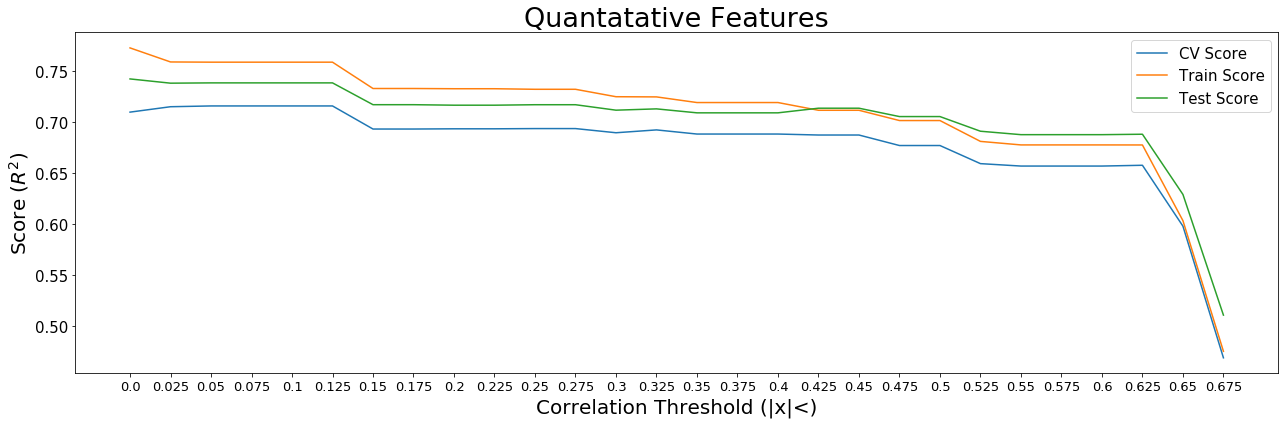

In [27]:
corr_r2_plot(df, quantatative_cols,
             title_name = 'Quantatative Features',
             corr_start=0, corr_end=0.7, corr_step=0.025)

Observations: 
    - R^2 Score (CV score, train score, test score) and correlation threshold relationship
        - The model over-fits when features with higher correlation to the target are included.
        - The model starts to fail when only the features with absolute correlation value more than about 0.6 are included.

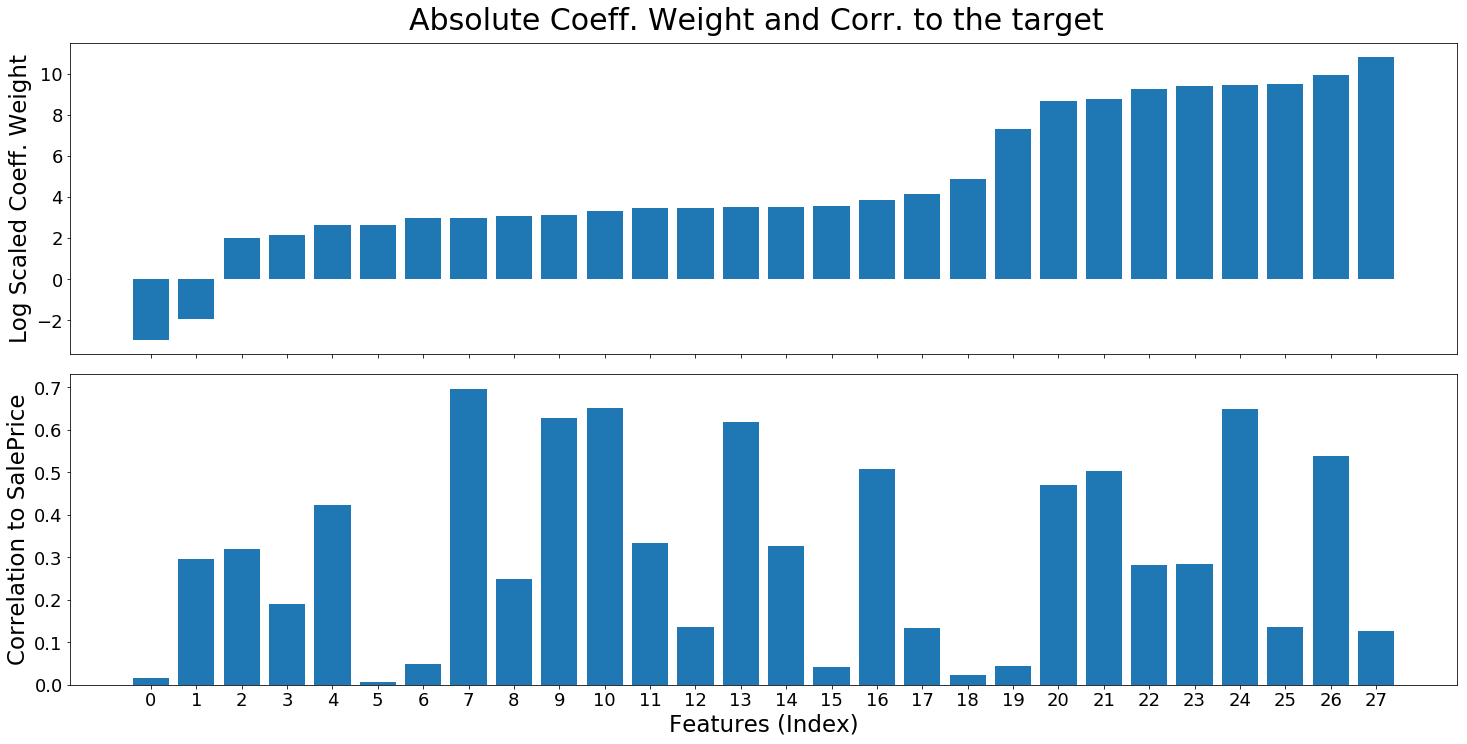

In [28]:
coef_corr_plot(df, quantatative_cols, absolute = True)

Observation:
    - Although the magnitude of coefficient weight and correlation of the features both impact how good the model works, they are not correlated to each other.

In [29]:
X = df[quantatative_cols].drop('SalePrice', axis = 1)
y = df['SalePrice']

Trial 1
{'MAE': 25551.71517493141, 'SSE': 643075627286.6373, 'MSE': 1253558727.6542637, 'RMSE': 35405.631298626264, 'R2': 0.7958381630832966, 'Adjusted_R2': 0.784027147724479}
Trial 2
{'MAE': 27020.18962263661, 'SSE': 1574660605951.4165, 'MSE': 3069513851.7571473, 'RMSE': 55403.19351587188, 'R2': 0.5675829629181454, 'Adjusted_R2': 0.5425671012687815}
Trial 3
{'MAE': 25689.523235097007, 'SSE': 728506770619.1207, 'MSE': 1420091170.7975063, 'RMSE': 37684.097054294754, 'R2': 0.8022682654147321, 'Adjusted_R2': 0.7908292394469891}


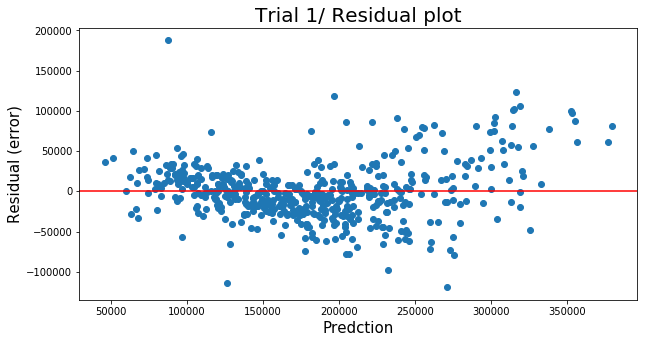

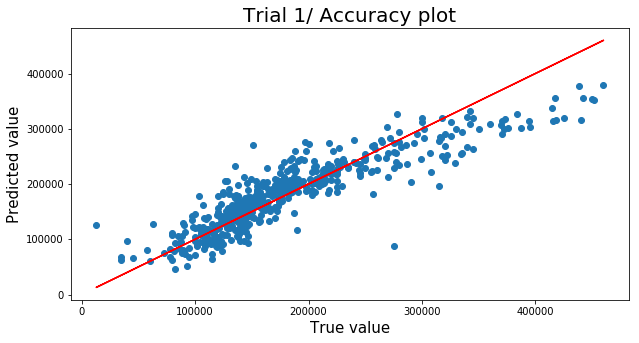

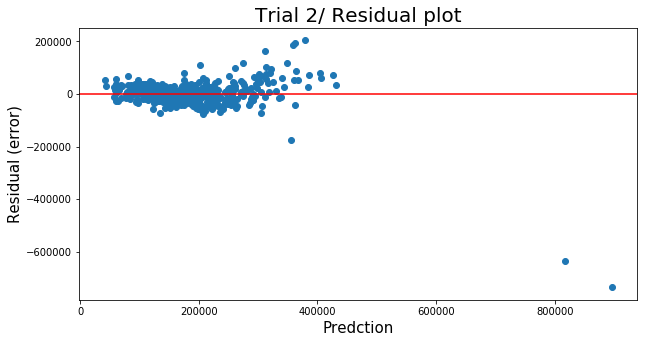

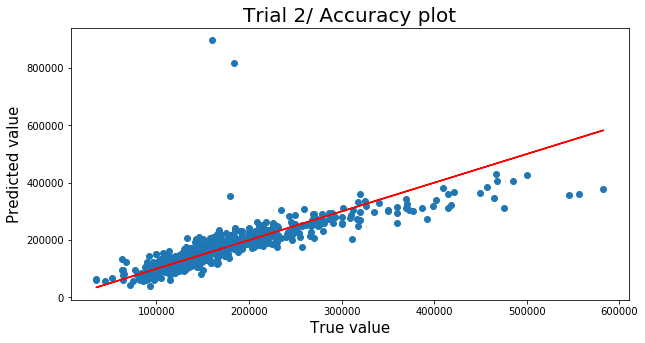

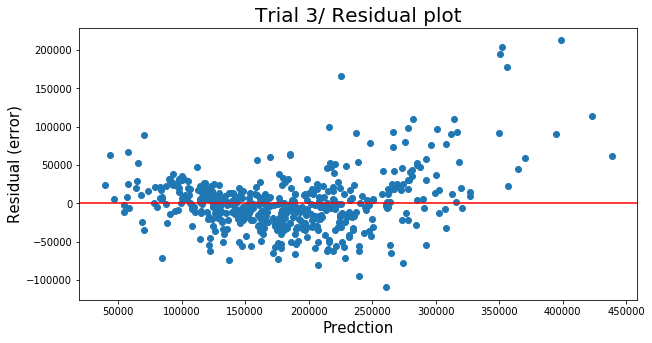

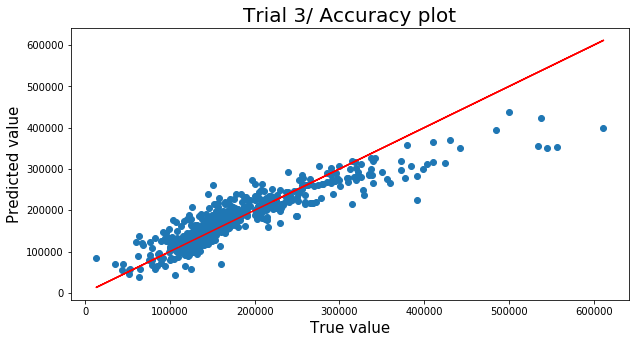

In [30]:
model_fit(X, y)

Observations:

- There seems to be outlisers (refer to 'trial 2').
- Prediction tends to fail more on the higher target range.

<a id='cat'></a>
## Categorical Features

<a id='cat_clean'></a>
### 1. Cleaning

In [31]:
df[categorical_cols].isnull().sum()

MS SubClass         0
Overall Qual        0
Overall Cond        0
Year Built          0
Year Remod/Add      0
Garage Yr Blt     114
Mo Sold             0
Yr Sold             0
dtype: int64

In [32]:
df[non_numeric_cols].isnull().sum().sort_values(ascending = False)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Condition 1          0
Neighborhood         0
Condition 2          0
Bldg Type            0
Sale Type            0
Lot Config           0
Land Slope           0
Roof Style           0
Utilities            0
Land Contour         0
Lot Shape            0
Street               0
House Style          0
Foundation           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Exter Qual           0
Exter Cond           0
Heating              0
Heating QC           0
Central Air          0
Electrical           0
Kitchen Qual         0
Functional           0
Paved Drive          0
MS Zoning            0
dtype: int64

#### Garage Yr Blt 

In [33]:
# 'Garage Yr Blt' column typo corrected (2207.0 -> 2007)
# Assume 2207.0 is typo of 2007 because Year Remod/Add and Yr Sold are 2007 and 2207 is similiar to 2007.

# Garage Yr Blt: 1895 ~ 2010

df['Garage Yr Blt'].replace(2207.0, 2007, inplace = True)

In [34]:
# Checking average sale price for the properties with newer Garages

df.loc[ df['Garage Yr Blt'] > 1975, :]['SalePrice'].mean()

218789.62969588552

In [35]:
# Checking average sale price for the properties with older Garages

df.loc[ df['Garage Yr Blt'] < 1975, :]['SalePrice'].mean()

140687.758186398

In [36]:
df.loc[df['Garage Yr Blt'].isnull(), ['Garage Yr Blt', 'Garage Finish']]['Garage Finish'].unique()

array([nan], dtype=object)

#### Observation: 
- If 'Garage Yr Blt' is NA, it is becuase there is no garage in the property.

#### Plan:
- NA values in 'Garage Yr Blt' will be 'no_garage'
- old garage will be 'old_garage'
- new garage will be 'new_garage'
- Dummy out the 'Garage Yr Blt'

In [37]:
def Garage_Yr_Blt_filler(row):
    
    """
    Replace each row of 'Garage Yr Blt' column as following:
        NA: 'no_garage'
        >= 1975: 'new_garage'
        < 1975: 'old_garage'
    
    Parameter:
        - row: series/ ex) 'dataframe.apply(lf_filler, axis = 1)'
    """
    
    if np.isnan(row['Garage Yr Blt']):
        fill = 'no_garage'
        
    elif row['Garage Yr Blt'] >= 1975:
        fill = 'new_garage'
        
    else:
        fill = 'old_garage'
    return fill

In [38]:
df['Garage Yr Blt'] = df.apply(Garage_Yr_Blt_filler, axis = 1)

In [39]:
df['Garage Yr Blt'].value_counts()

new_garage    1143
old_garage     794
no_garage      114
Name: Garage Yr Blt, dtype: int64

In [40]:
df = pd.get_dummies(df, columns= ['Garage Yr Blt'], drop_first=True)

#### Yr Sold - Year Built

In [41]:
df['Year Built'].value_counts()

2005    102
2006     99
2007     78
2004     72
2003     64
       ... 
1911      1
1893      1
1885      1
1879      1
1872      1
Name: Year Built, Length: 113, dtype: int64

In [42]:
df['Yr Sold'].value_counts()

2007    498
2009    446
2006    438
2008    435
2010    234
Name: Yr Sold, dtype: int64

In [43]:
# Create 'age_when_sold' column by df[Yr Sold] - df[Year Built]

df['age_when_sold'] = df['Yr Sold'] - df['Year Built']

In [44]:
# Drop 'Yr Sold' and 'Year Built' as the two columns are correlated to 'age_when_sold'

df = df.drop(['Yr Sold', 'Year Built'], axis = 1)

#### Overall Qual

In [45]:
def plot_hist(df, col,xlabel,w = 6, h = 4 , mean_line = 'True'):
    plt.figure(figsize = (w, h))
    plt.hist(df[col])
    plt.xlabel(xlabel)
    plt.ylabel('frequency')
    plt.title(xlabel + " Histogram")
    if mean_line:
        plt.axvline(df[col].mean(), color='red' )

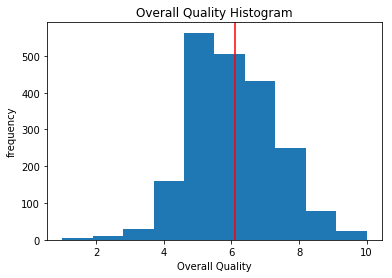

In [46]:
plot_hist(df, 'Overall Qual', 'Overall Quality')

#### Overall Cond

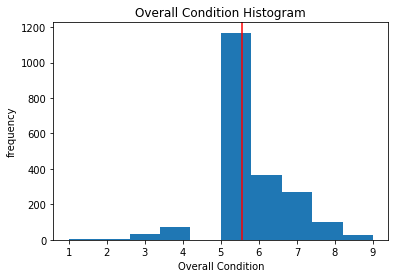

In [47]:
plot_hist(df, 'Overall Cond', 'Overall Condition')

In [48]:
df.loc[:,['Overall Qual', 'Overall Cond']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
Overall Qual    2051 non-null int64
Overall Cond    2051 non-null int64
dtypes: int64(2)
memory usage: 32.2 KB


Observations:

- Overall Qual and Overall Cond are both has numerically quantatated score.
- Overall Qual is more normally distributed than Overall Con.

#### Neighborhood

In [49]:
nbr_group = df.loc[:, ['Neighborhood', 'SalePrice']].groupby('Neighborhood').mean()
nbr_group = nbr_group.reset_index()
nbr_group.head()

,Neighborhood,SalePrice
0,Blmngtn,200417.681818
1,Blueste,144566.666667
2,BrDale,103371.052632
3,BrkSide,127022.697368
4,ClearCr,217490.074074


Text(0.5, 1.0, 'Average Sale Price by Neighborhood')

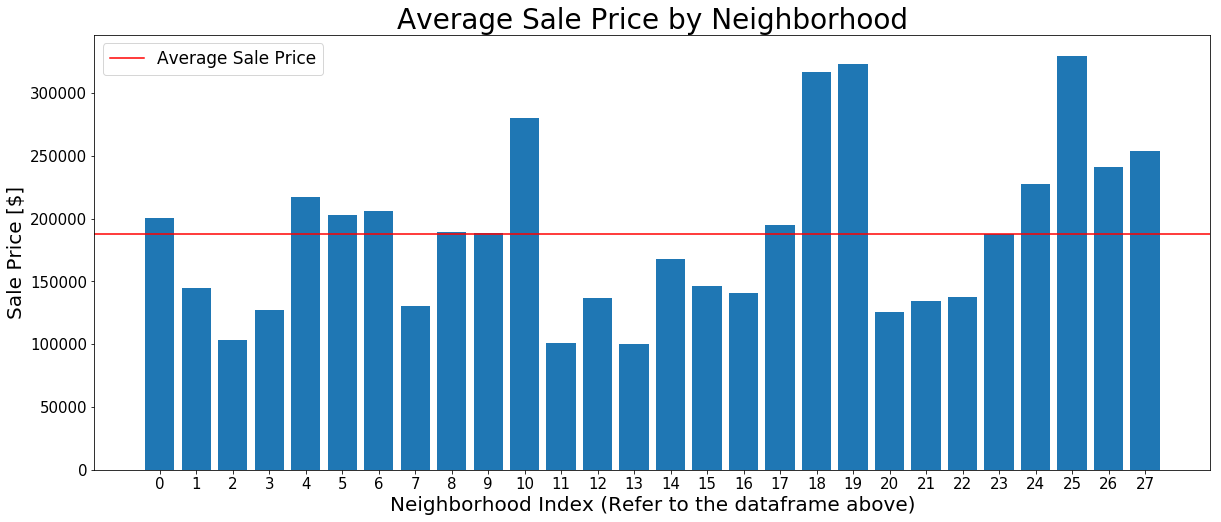

In [50]:
plt.figure(figsize = (20,8))
plt.bar(nbr_group.index, nbr_group.iloc[:,1].values)
plt.axhline(nbr_group.iloc[:,1].values.mean(), color='red', label = 'Average Sale Price')
plt.xlabel('Neighborhood Index (Refer to the dataframe above)', fontsize = 20)
plt.ylabel('Sale Price [$]', fontsize = 20)
plt.xticks(ticks = np.arange(len(list(nbr_group.index))),
           labels = list(nbr_group.index), 
           fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 17)
plt.title('Average Sale Price by Neighborhood', fontsize = 28)

Observation:
- Neighborhood can be classified into groups whose average sale price is higher than overall average and lower than overall average.

In [51]:
# Dividing 'Neighborhood' into two categories

g_nbr = nbr_group.loc[nbr_group['SalePrice'] > nbr_group.iloc[:,1].values.mean(), :]['Neighborhood'].values
w_nbr = nbr_group.loc[nbr_group['SalePrice'] < nbr_group.iloc[:,1].values.mean(), :]['Neighborhood'].values

In [52]:
w_nbr

array(['Blueste', 'BrDale', 'BrkSide', 'Edwards', 'IDOTRR', 'Landmrk',
       'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'OldTown', 'SWISU',
       'Sawyer'], dtype=object)

In [53]:
"""
Binarize 'Neighborhood' column as following:
    - 1: the average sale price of the property in the neighborhood is higer than overall average.
    - 0: the average sale price of the property in the neighborhood is higer than overall average.
"""

df['Neighborhood'] = df['Neighborhood'].apply(lambda x: 1 if x in g_nbr else 0)

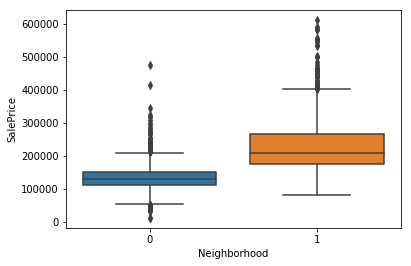

In [54]:
sns.boxplot(x = 'Neighborhood', y = 'SalePrice' ,data = df)

#### Central Air, Street
    - These two features have two items each.
    - Binarize them into 0 and 1

#### a. Central Air

In [55]:
df.loc[:, ['Central Air', 'SalePrice']].groupby('Central Air').mean()

,SalePrice
Central Air,
N,100575.078014
Y,187441.503665


In [56]:
df['Central Air'] = df['Central Air'].apply(lambda x: 1 if x == 'Y' else 0)

In [57]:
df.loc[:, ['Central Air', 'SalePrice']].groupby('Central Air').mean()

,SalePrice
Central Air,
0,100575.078014
1,187441.503665


#### b. Street

In [58]:
df.loc[:, ['Street', 'SalePrice']].groupby('Street').mean()

,SalePrice
Street,
Grvl,86901.428571
Pave,181793.565558


In [59]:
df['Street'] = df['Street'].apply(lambda x: 1 if x == 'Pave' else 0)

In [60]:
df.loc[:, ['Street', 'SalePrice']].groupby('Street').mean()

,SalePrice
Street,
0,86901.428571
1,181793.565558


#### Columns with ranking items (ex. good, average, bad)
    - Columns: 'Heating QC', 'Kitchen Qual', 'Exter Qual', 'Exter Cond'
    - Assign numerical score

In [61]:
def unique_vals(df):
    """
    Return dictionary that has
         key == column names
         value == the column's unique values
    """
    
    val_dic = {}
    for col in df.columns:
        val_dic.update({col: df[col].unique()})
    return val_dic

In [62]:
# Make dictionary to turn string score to numerical score

str_score_5 = ['Ex','Gd','TA','Fa', 'Po']
num_score_5 = np.arange(5,-1,-1)
score_5_dict = dict(zip(str_score_5, num_score_5))

str_score_4 = ['Ex','Gd','TA','Fa']
num_score_4 = np.arange(4,-1,-1)
score_4_dict = dict(zip(str_score_4, num_score_4))

In [63]:
score_4_dict

{'Ex': 4, 'Fa': 1, 'Gd': 3, 'TA': 2}

In [64]:
# View unique values
ranking_cols =['Heating QC', 'Kitchen Qual',
                      'Exter Qual', 'Exter Cond']

score_df = df.loc[:, ranking_cols]
unique_vals(score_df)

{'Exter Cond': array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object),
 'Exter Qual': array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object),
 'Heating QC': array(['Ex', 'TA', 'Gd', 'Fa', 'Po'], dtype=object),
 'Kitchen Qual': array(['Gd', 'TA', 'Fa', 'Ex'], dtype=object)}

In [65]:
# Turn string score to numerical score

df['Exter Cond'] = df['Exter Cond'].map(score_5_dict)
df['Heating QC'] = df['Heating QC'].map(score_5_dict)
df['Kitchen Qual'] = df['Kitchen Qual'].map(score_4_dict)
df['Exter Qual'] = df['Exter Qual'].map(score_4_dict)

<a id='cat_clean_NA'></a>

### Cleaning NA values

In [66]:
df.isnull().sum().sort_values(ascending=False).head(16)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Garage Finish      114
Garage Qual        114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Qual           55
Bsmt Cond           55
BsmtFin Type 1      55
Mas Vnr Type        22
Year Remod/Add       0
dtype: int64

Observation:

- Meaning of all NA values in the columns are specified in the data dictionary.(http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)
- NA values in 'Misc Feature' means no miscellaneous feature not covered in other categories. This does not seem significant. Therefore, drop this column.

Plan:

- Drop 'Misc Feature' column.
- Turn NA value in rest of the columns to a string that represents its meaning.
- The columns are to be dummied out.

#### a. Misc Feature

In [67]:
df = df.drop('Misc Feature', axis = 1)

In [68]:
null_cols = ['Pool QC', 'Alley', 'Fence',
             'Fireplace Qu', 'Garage Finish',
             'Garage Qual', 'Garage Cond', 'Garage Type',
             'Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual',
             'Bsmt Cond', 'BsmtFin Type 1', 'Mas Vnr Type']

#### b. Pool QC

In [69]:
df['Pool QC'] = df.loc[:,'Pool QC'].fillna('no_pool')

#### c. Alley

In [70]:
df['Alley'] = df.loc[:,'Alley'].fillna('no_alley')

#### d. Fence

In [71]:
df['Fence'] = df.loc[:,'Fence'].fillna('no_fence')

#### e. FireplaceQu

In [72]:
df['Fireplace Qu'] = df.loc[:,'Fireplace Qu'].fillna('no_fireplace')

#### f. Garage Finish

In [73]:
df['Garage Finish'] = df.loc[:,'Garage Finish'].fillna('no_garage')

#### g. Garage Qual

In [74]:
df['Garage Qual'] = df.loc[:,'Garage Qual'].fillna('no_garage')

#### h. Garage Cond

In [75]:
df['Garage Cond'] = df.loc[:,'Garage Cond'].fillna('no_garage')

#### i. Garage Type

In [76]:
df['Garage Type'] = df.loc[:,'Garage Type'].fillna('no_garage')

#### j. Bsmt Exposure 

In [77]:
df['Bsmt Exposure'] = df.loc[:,'Bsmt Exposure'].fillna('no_basement')

#### k. BsmtFin Type 1, 2

In [78]:
df['BsmtFin Type 1'] = df.loc[:,'BsmtFin Type 1'].fillna('no_basement')
df['BsmtFin Type 2'] = df.loc[:,'BsmtFin Type 2'].fillna('no_basement')

#### l. Bsmt Qual, Cond

In [79]:
df['Bsmt Qual'] = df.loc[:,'Bsmt Qual'].fillna('no_basement')
df['Bsmt Cond'] = df.loc[:,'Bsmt Cond'].fillna('no_basement')

#### m. Mas Vnr Type 

In [80]:
df['Mas Vnr Type'] = df.loc[:,'Mas Vnr Type'].fillna('no_mas_vnr')

In [81]:
df.isnull().sum().sort_values(ascending = False)

age_when_sold               0
Garage Yr Blt_old_garage    0
Roof Style                  0
Roof Matl                   0
Exterior 1st                0
                           ..
TotRms AbvGrd               0
Functional                  0
Fireplaces                  0
Fireplace Qu                0
Id                          0
Length: 80, dtype: int64

<a id='cat_dummy'></a>

### Get Dummy Variables (Categorical Features Only)

In [82]:
to_be_dummy_cols = df.loc[:, df.dtypes == object].columns

In [83]:
df = pd.get_dummies(df, columns= to_be_dummy_cols, drop_first=True)

<a id='cat_model'></a>

### Modeling (Linear Regression)

In [84]:
all_cols = list(df.columns[2:])4

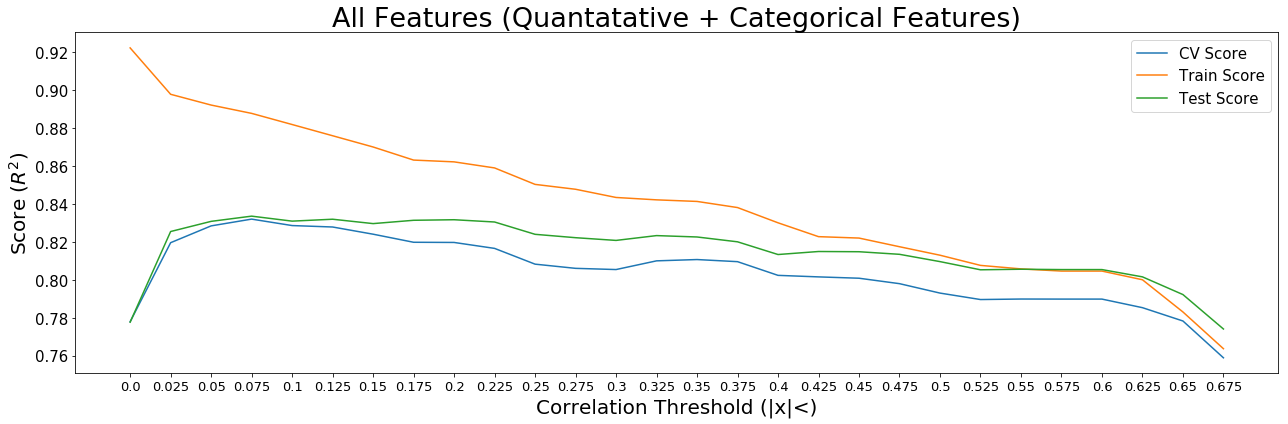

In [85]:
corr_r2_plot(dataframe = df, cols = all_cols,
             title_name = 'All Features (Quantatative + Categorical Features)',
             corr_start=0)

Observations:
    - The gap between train score has gotten larger, compared to the model when only quantatitive features were included. This suggests that the overfit of the model has gotten worse.

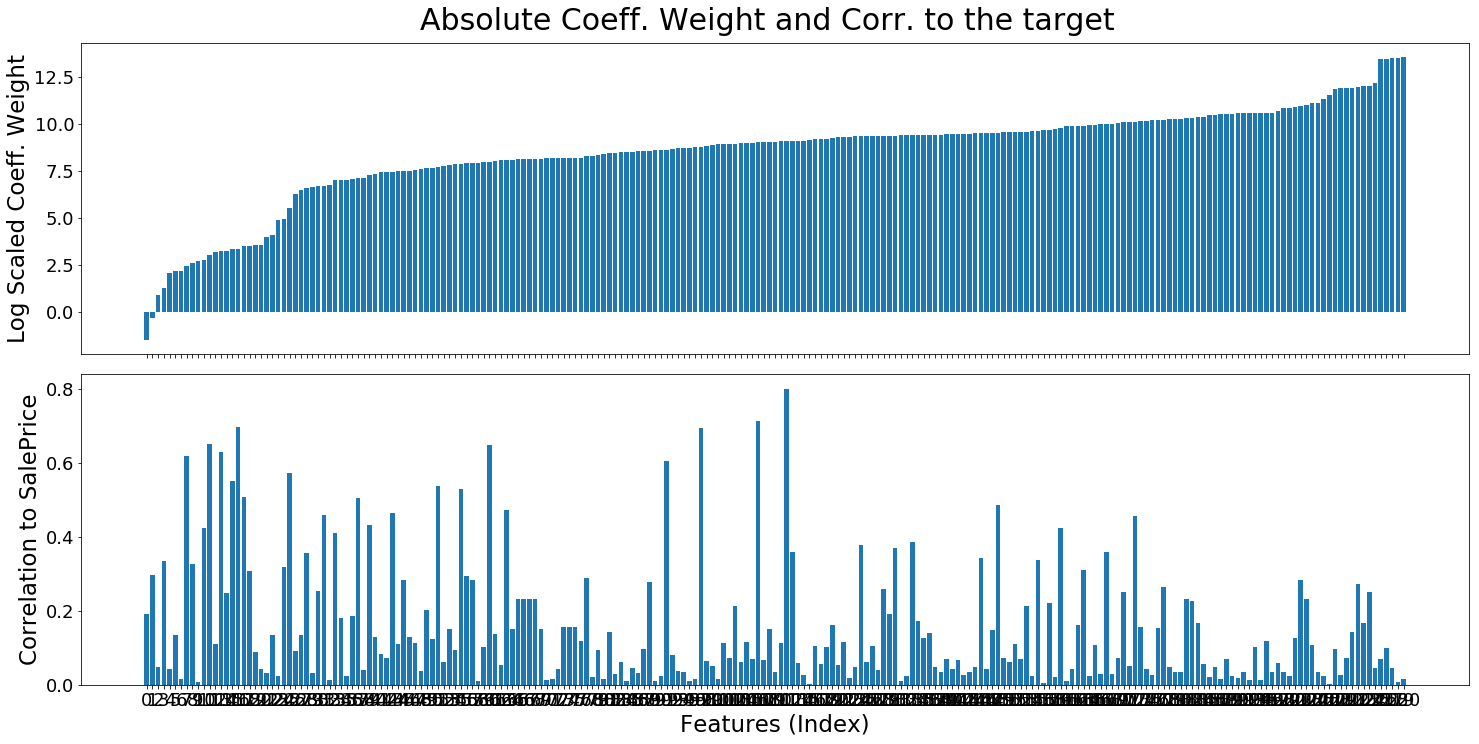

In [86]:
coef_corr_plot(dataframe = df, cols = all_cols, absolute = True)

Observations:
    - Relationship between the magnitude of coefficient weight and correlation is not observed. This was also observed in the model that included only the quantativie features. 

In [87]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df['SalePrice']

Trial 1
{'MAE': 17660.447713899946, 'SSE': 297082932560.045, 'MSE': 579109030.3314717, 'RMSE': 24064.68429735723, 'R2': 0.9056829482342904, 'Adjusted_R2': 0.8340538470651433}
Trial 2
{'MAE': 21249.12794261313, 'SSE': 1323726412813.281, 'MSE': 2580363377.8036666, 'RMSE': 50797.277267622, 'R2': 0.6364919201176921, 'Adjusted_R2': 0.3604256463926405}
Trial 3
{'MAE': 17096.557133790422, 'SSE': 349209177690.1259, 'MSE': 680719644.6201285, 'RMSE': 26090.60452768637, 'R2': 0.905217440355315, 'Adjusted_R2': 0.8332348091474959}


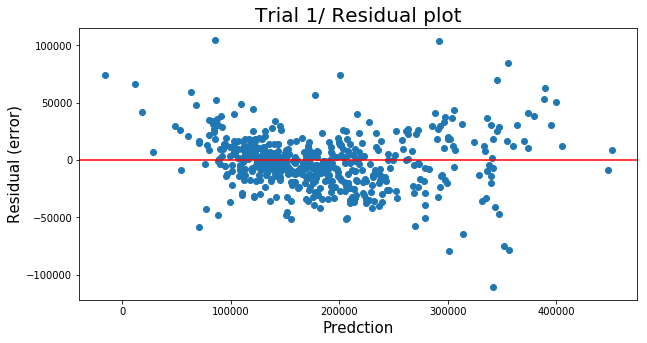

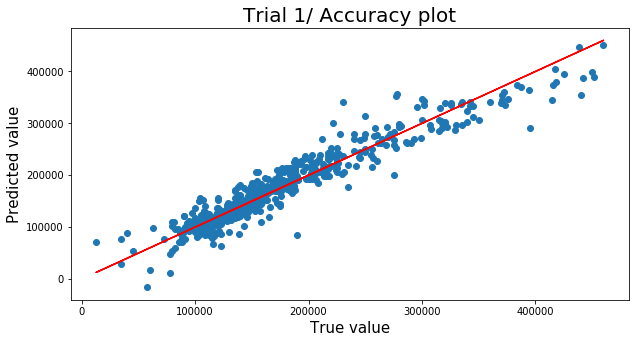

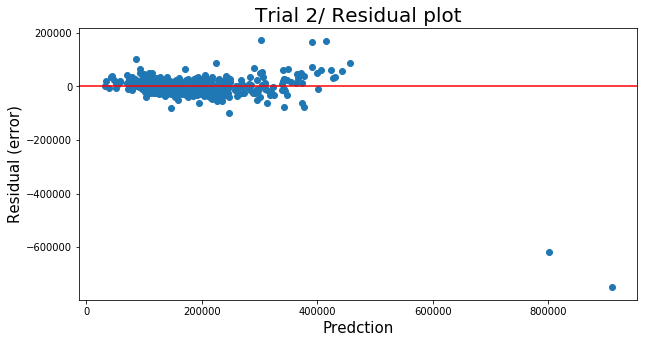

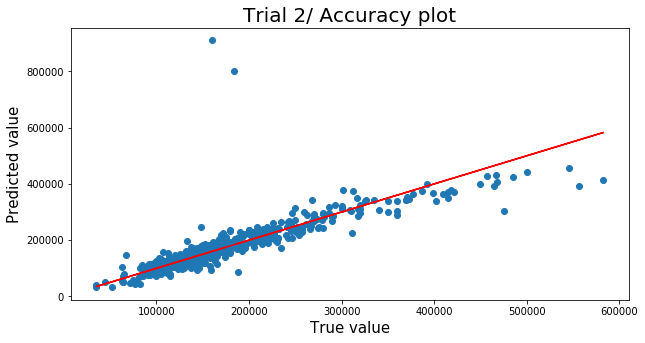

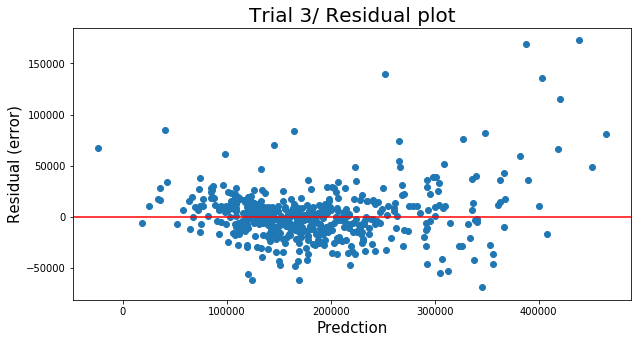

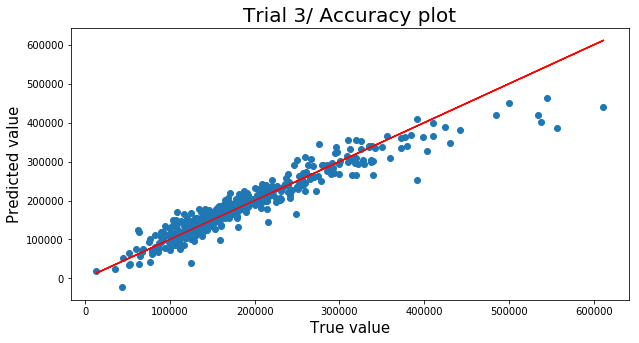

In [88]:
model_fit(X,y)

Observations: 
    - Two outliers are observed. (Refer to trial 2)
    - The model tend to fail predicting the target when the actual target is higher.

<a id='feat_eng'></a>

### Feature Engineering (Get Interaction Terms)

- Create interaction terms with qunatatative features (numerical quantative columns, columns with numerical ranking score).

In [89]:
# Generate list of column names to create interaction terms with
interact_term_cols = numeric_cols + ranking_cols + ['age_when_sold']

In [90]:
# Remove columns that are not needed
cols_to_remove = ['Id', 'PID', 'Garage Yr Blt', 'Yr Sold', 'Year Built', 'SalePrice']
for col in cols_to_remove:
    interact_term_cols.remove(col)

In [91]:
# Make dataframe of features to make interaction terms with
X_interact_df = df[interact_term_cols]

In [92]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_interact = poly.fit_transform(X_interact_df)
poly_df = pd.DataFrame(X_interact, columns = poly.get_feature_names(interact_term_cols))

/Users/dae/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:1263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for c in combinations)


In [93]:
# merge interaction terms to the original dataframe

df = pd.merge(df, poly_df, on=df.index).drop('key_0', axis =1)

In [94]:
df.shape

(2051, 1003)

<a id='fin'></a>

### Modeling (Lasso)

In [95]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df['SalePrice']

In [96]:
ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [97]:
lasso = LassoCV(n_alphas = 200, # Pick 200 alpha value and see what works 
                                # It's like 'alphas = ridge_alphas' for RidgeCV
                cv = 5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [98]:
lasso.alpha_

2073.2256477079122

In [99]:
lasso.score(X_train_scaled, y_train)

0.925638125163485

In [100]:
lasso.score(X_test_scaled, y_test)

0.768653885324173

In [101]:
coef_dict = dict(zip(X.columns, lasso.coef_))
coef_df = pd.DataFrame(data = list(coef_dict.items()), columns = ['feature', 'coef'])
coef_df['abs_coef'] = abs(coef_df['coef'])
coef_df.sort_values(by = 'abs_coef', ascending = False)

,feature,coef,abs_coef
381,Overall Qual Gr Liv Area,18483.143396,18483.143396
496,Mas Vnr Area Pool Area,-12198.312661,12198.312661
720,Gr Liv Area Kitchen Qual,9766.494355,9766.494355
646,1st Flr SF Exter Qual,8057.291843,8057.291843
391,Overall Qual Garage Area,7560.231918,7560.231918
...,...,...,...
341,Lot Area Bsmt Unf SF,0.000000,0.000000
342,Lot Area Total Bsmt SF,0.000000,0.000000
343,Lot Area 1st Flr SF,0.000000,0.000000
344,Lot Area 2nd Flr SF,0.000000,0.000000


Trial 1
Train Score: 0.8796333263103786
Test Score: 0.8915965835519322
RMSE: 25799.21816337327
Trial 2
Train Score: 0.9461418088600405
Test Score: 0.43952647473940387
RMSE: 63075.53631528658
Trial 3
Train Score: 0.9270722475165483
Test Score: 0.9222405855560873
RMSE: 23631.778987233443


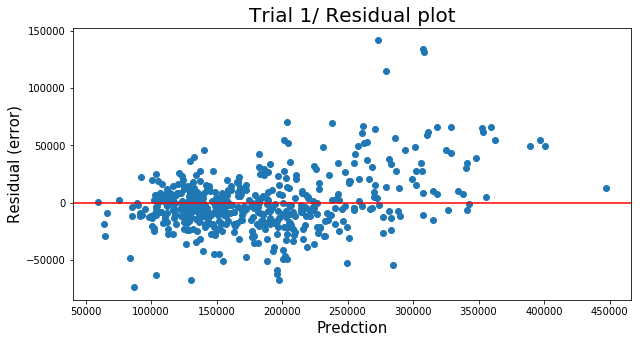

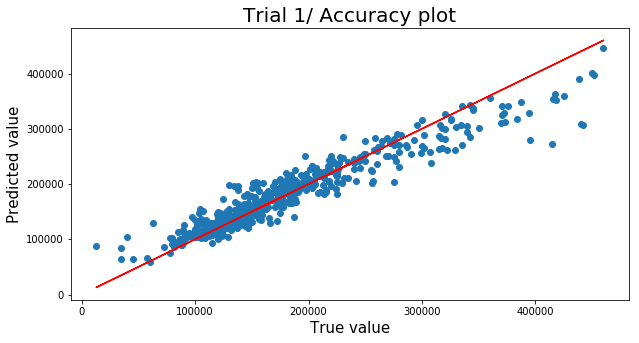

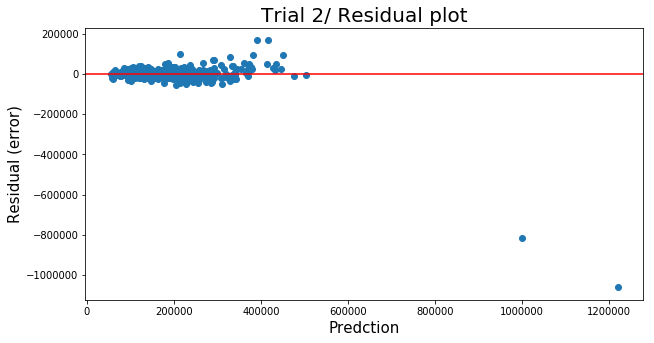

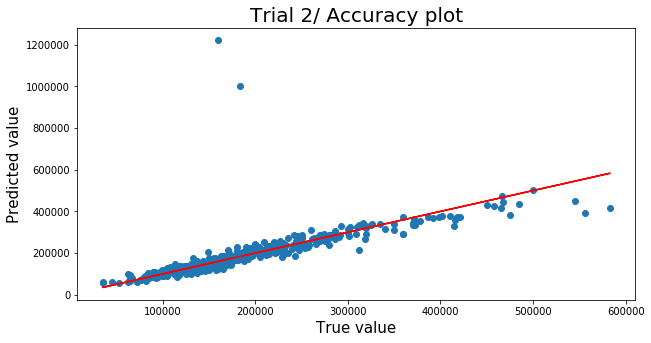

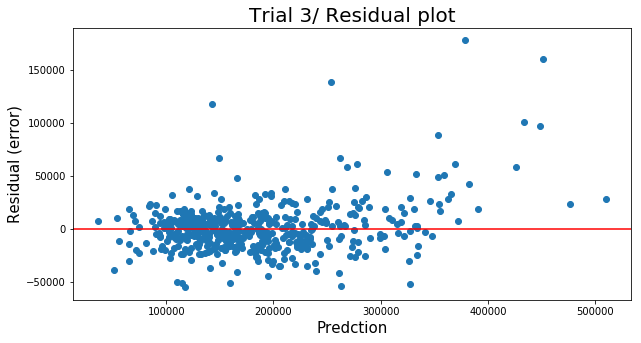

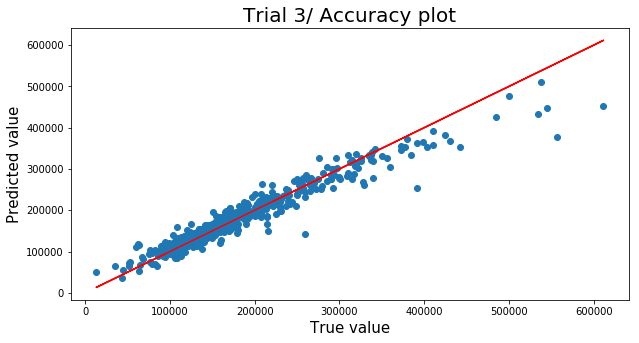

In [102]:
lasso_plot = LassoCV(n_alphas = 200, cv = 5)


model_fit_sc(X, y, model = lasso_plot)

Observations:
- Overfit significantly improved compared to Linear Rigression model.
- Some outliers seem to impact the model's performance (Refer to Trial 2)

<a id='outlier'></a>

### Outlier Handling

In [103]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df['SalePrice']

In [104]:
# Test LassoCV with random state = 112 to simulate the trial 2 model test result.

rs = 112

ss = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lr = LassoCV(n_alphas = 200, cv = 5)

lr.fit(X_train_sc, y_train)

X_test['preds'] = lr.predict(X_test_sc)
X_test['resids'] = y_test - X_test.loc[:,'preds']

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [105]:
# Checking out the outlier
X_test['preds'].nlargest(5)

960     1.220872e+06
1885    1.000794e+06
800     5.042325e+05
1117    4.760593e+05
138     4.507192e+05
Name: preds, dtype: float64

In [106]:
# Checking out the outlier

X_test['resids'].nsmallest(5)

960    -1.060872e+06
1885   -8.169437e+05
1515   -5.670508e+04
1201   -5.150407e+04
1965   -4.813020e+04
Name: resids, dtype: float64

In [107]:
# Checking out the outliers
outlier_index = [960, 1885]
df.loc[(df.index.isin(outlier_index)),:]

,Id,PID,MS SubClass_x,Lot Frontage_x,Lot Area_x,Street,Neighborhood,Overall Qual_x,Overall Cond_x,Year Remod/Add_x,...,Kitchen Qual^2,Kitchen Qual Exter Qual,Kitchen Qual Exter Cond,Kitchen Qual age_when_sold,Exter Qual^2,Exter Qual Exter Cond,Exter Qual age_when_sold,Exter Cond^2,Exter Cond age_when_sold,age_when_sold^2
960,1499,908154235,60,313.0,63887,1,0,10,5,2008,...,16.0,16.0,12.0,0.0,16.0,12.0,0.0,9.0,0.0,0.0
1885,2181,908154195,20,128.0,39290,1,0,10,5,2009,...,16.0,16.0,12.0,-4.0,16.0,12.0,-4.0,9.0,-3.0,1.0


In [108]:
# dropping outliers

df = df.drop(outlier_index)

In [109]:
X = df.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df['SalePrice']

Trial 1
Train Score: 0.9457013462524892
Test Score: 0.9335063649640424
RMSE: 20503.179712580964
Trial 2
Train Score: 0.9505048469431486
Test Score: 0.9269830743874601
RMSE: 21393.38083238939
Trial 3
Train Score: 0.943280007544239
Test Score: 0.9394123078385238
RMSE: 20383.854497584514


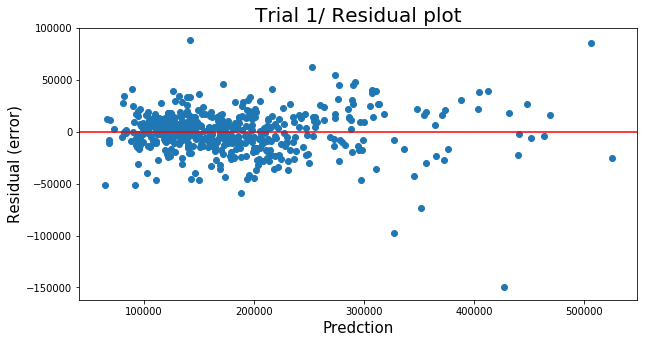

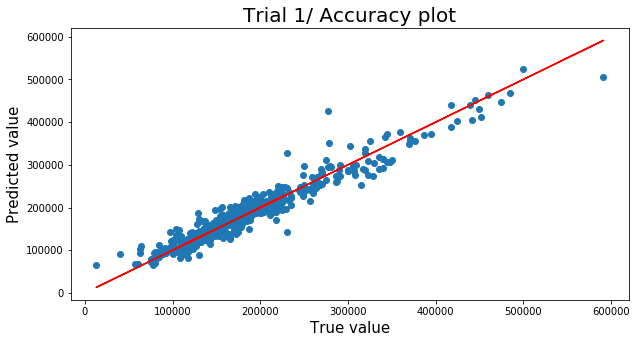

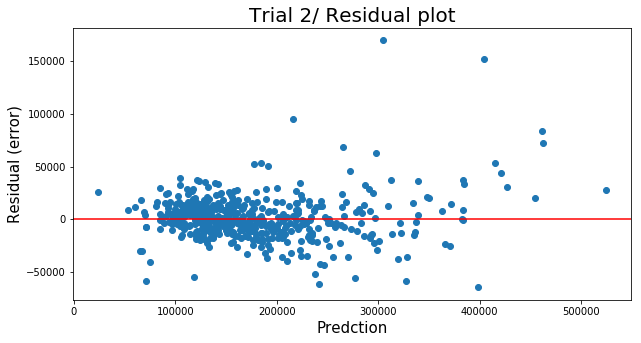

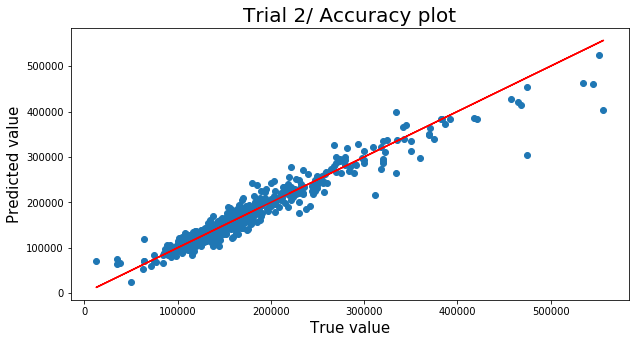

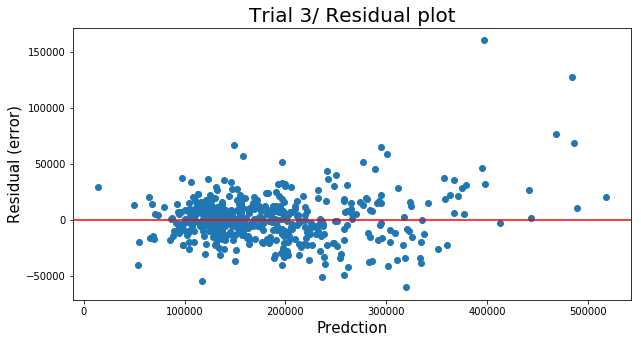

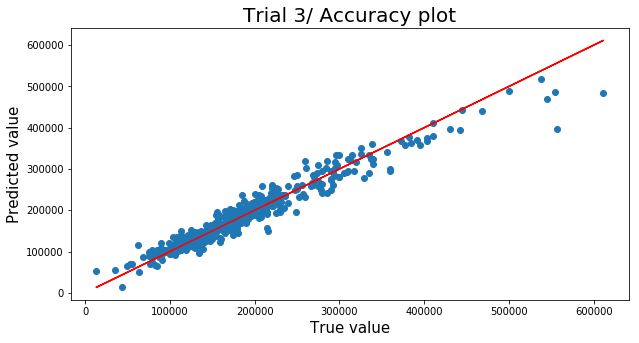

In [110]:
lasso_plot = LassoCV(n_alphas = 200, cv = 5)
model_fit_sc(X, y, model = lasso_plot)

Observations:
    - Removing the outliers significantly imporved the prediction result.
    

<a id='fin_reg'></a>

### Final Modeling (Linear Regression)
- Plot features selected from Lasso model in MLR model

In [111]:
lasso_cols = list(coef_df.loc[coef_df['abs_coef'] != 0,:]['feature'].values) + ['SalePrice']

In [112]:
# Show all columns that were selected
lasso_cols

49

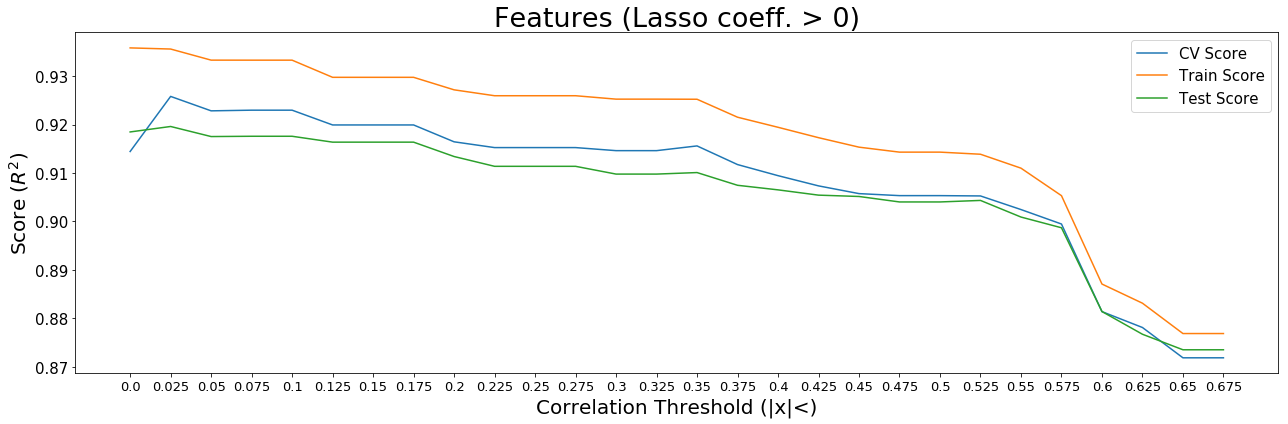

In [118]:
corr_r2_plot(dataframe = df, cols = lasso_cols,
             title_name = 'Features (Lasso coeff. > 0)',
             corr_start=0)

Observation:

- The model still overfit (high variance) with linear regression model.
- It is determined that regularization model will be the better fit.

In [114]:
# Make new dataframes that uses only the features that had lasso coefficient > 0

df_n = df[['Id', 'PID']+lasso_cols] 

<a id='fin_ridge'></a>

### Final Modeling (Ridge)

In [115]:
X = df_n.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df_n['SalePrice']

In [116]:
ridge_alphas = np.logspace(0, 5 ,100)

ridge = RidgeCV(alphas = ridge_alphas, cv = 5) 

Trial 1
Train Score: 0.9308162129241088
Test Score: 0.9350230645383122
RMSE: 20267.995210727124
Trial 2
Train Score: 0.9330460010187117
Test Score: 0.9294408809306469
RMSE: 21030.239847852954
Trial 3
Train Score: 0.9310113844603264
Test Score: 0.933155813461414
RMSE: 21410.456482942238


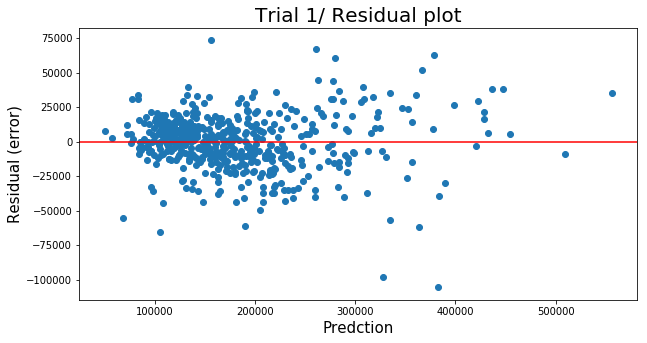

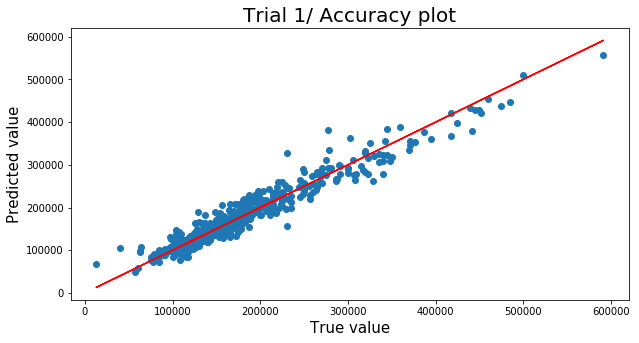

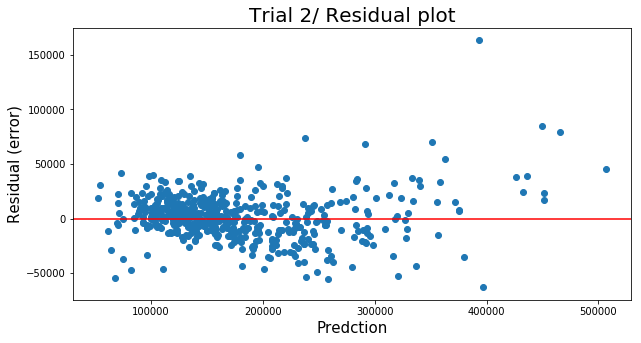

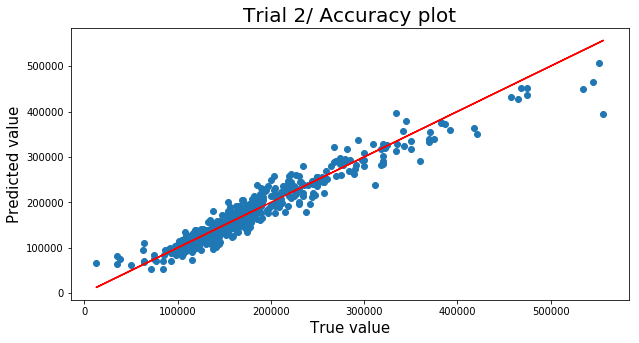

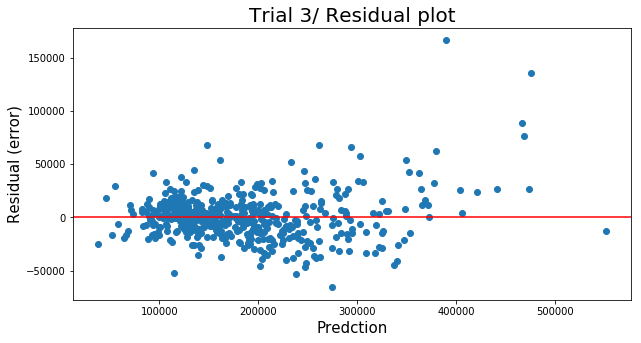

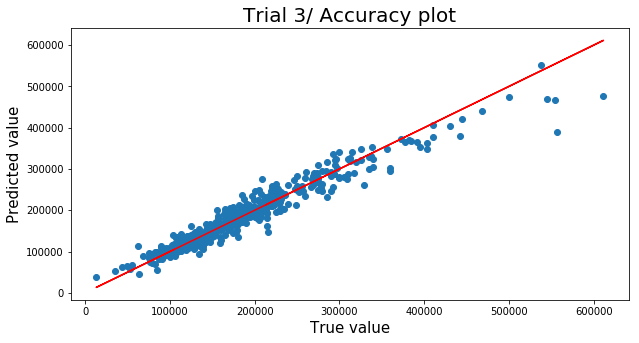

In [117]:
model_fit_sc(X, y, model = ridge)

Observations:
- Compared to Lasso model, variance was decrased (overfit improved)

In [115]:
# Make dataframe with Ridge coefficient weight

coef_dict = dict(zip(X.columns, ridge.coef_))
coef_df = pd.DataFrame(data = list(coef_dict.items()), columns = ['feature', 'coef'])
coef_df['abs_coef'] = abs(coef_df['coef'])
print("Ridge model result:")
coef_df.sort_values(by = 'abs_coef', ascending = False).head(20)

Ridge model result:


,feature,coef,abs_coef
22,Overall Qual Gr Liv Area,7719.508009,7719.508009
26,Overall Cond Gr Liv Area,6411.049331,6411.049331
46,Gr Liv Area Kitchen Qual,6330.412867,6330.412867
47,Gr Liv Area Exter Qual,5749.015838,5749.015838
21,Overall Qual Total Bsmt SF,5382.500431,5382.500431
24,Overall Qual Garage Area,5273.739382,5273.739382
34,BsmtFin SF 1 Exter Qual,4444.001072,4444.001072
45,Gr Liv Area Heating QC,4105.711470,4105.711470
17,Lot Area Overall Qual,4002.253428,4002.253428
40,Total Bsmt SF Kitchen Qual,3986.665053,3986.665053


<a id='kaggle'></a>

### Kaggle submission

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

lr = ridge
lr.fit(X_train_sc, y_train)

preds = lr.predict(X_test_sc)
resids = y_test - preds

print(f"Train Score: {lr.score(X_train_sc, y_train)}")
print(f"Test Score: {lr.score(X_test_sc, y_test)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, preds))}")

Train Score: 0.9273870411578571
Test Score: 0.9317297468710857
RMSE: 20775.28246360545


In [148]:
test = pd.read_csv('./datasets/clean_kaggle.csv')

In [157]:
kaggle_df = test[['Id']]

In [152]:
X_kaggle = test.drop('Id', axis = 1)

In [153]:
X_kaggle_sc = ss.transform(X_kaggle)

In [158]:
kaggle_df['SalePrice'] = lr.predict(X_kaggle_sc)

/Users/dae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [160]:
kaggle_df.to_csv('./datasets/kaggle_sub1.csv', index = False)

<a id='tuning'></a>

### Tuning (Analysis Using Log Scaled Target )

In [116]:
fin_columns = list(X.columns)+['SalePrice']

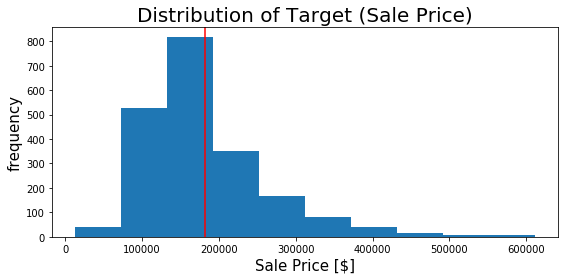

In [126]:
plt.figure(figsize = (8,4))
plt.hist(df_n['SalePrice']);
plt.axvline(df_n['SalePrice'].mean(), color = 'red')
plt.xlabel('Sale Price [$]', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.title('Distribution of Target (Sale Price)', fontsize = 20)
plt.tight_layout()

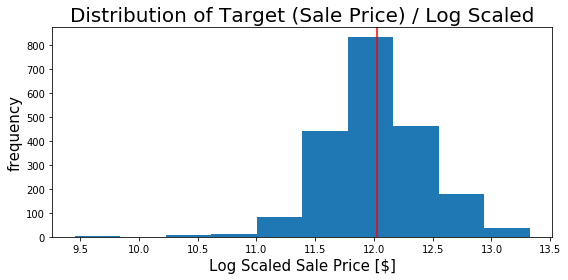

In [127]:
plt.figure(figsize = (8,4))
plt.hist(df_n['SalePrice'].apply(np.log));
plt.axvline(df_n['SalePrice'].apply(np.log).mean(), color = 'red')
plt.xlabel('Log Scaled Sale Price [$]', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.title('Distribution of Target (Sale Price) / Log Scaled', fontsize = 20)
plt.tight_layout()

Observations:
- Taking a log of the target make the distribution more normal.

<a id='tuning_model'></a>

### Modeling (with Log scaled target  / Ridge)

In [128]:
X = df_n.drop(['Id', 'PID', 'SalePrice'], axis = 1)
y = df_n['SalePrice']
y_log = df_n['SalePrice'].apply(np.log)

In [129]:
ridge_alphas = np.logspace(0, 5 ,100)

ridge = RidgeCV(alphas = ridge_alphas, cv = 5) 

Trial 1:
Train Score: 0.9008130363689533
Test Score: 0.8817965413203112
RMSE: 21332.775564816005
Trial 2:
Train Score: 0.9047413627070446
Test Score: 0.8729475555993722
RMSE: 21186.324302677946
Trial 3:
Train Score: 0.899257995158129
Test Score: 0.888380093398369
RMSE: 22876.55018599856


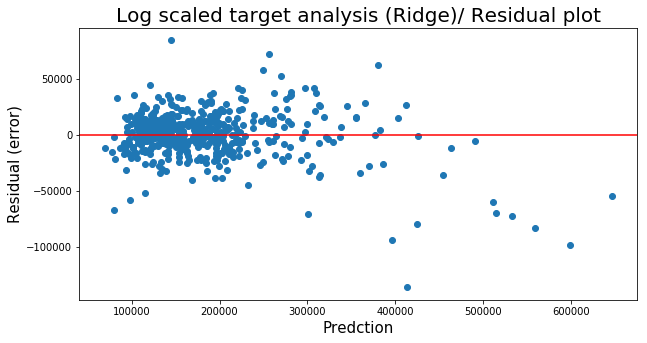

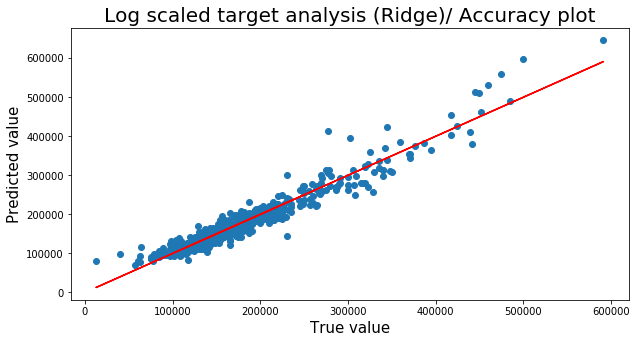

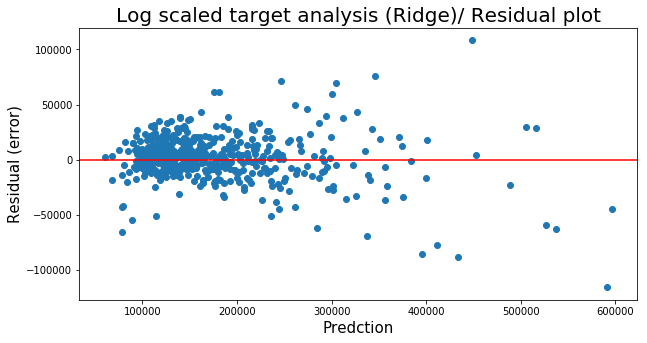

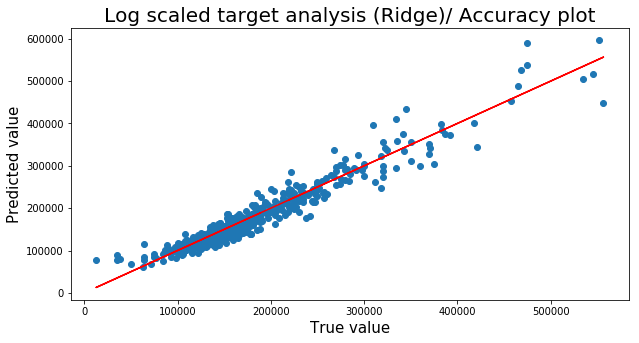

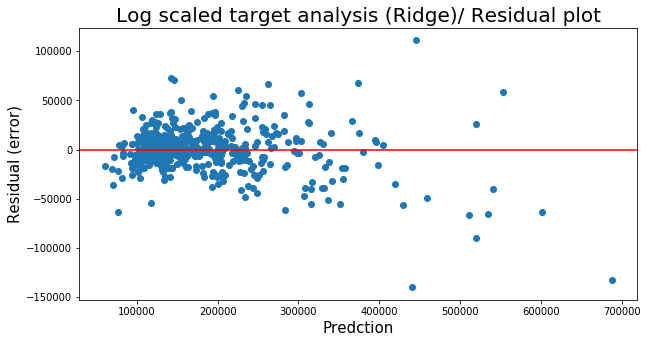

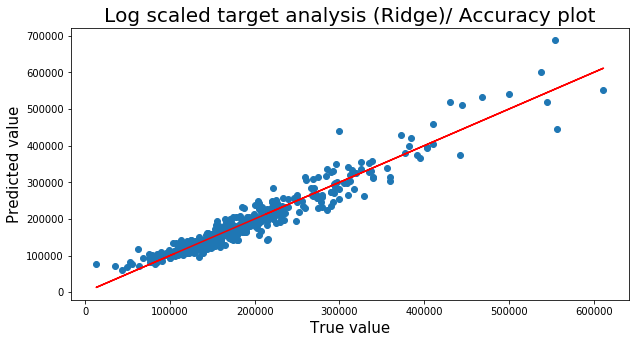

In [176]:
rs_list = [42, 112, 23]
for i, rs in enumerate(rs_list):

    ss = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state = rs)

    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)

    ridge = RidgeCV(alphas = ridge_alphas, cv = 5) 

    ridge.fit(X_train_sc, y_train)

    preds = ridge.predict(X_test_sc)
    preds = np.exp(preds)
    resids = np.exp(y_test) - preds

    print(f"Trial {i+1}:")
    print(f"Train Score: {ridge.score(X_train_sc, y_train)}")
    print(f"Test Score: {ridge.score(X_test_sc, y_test)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(np.exp(y_test), preds))}")

    resid_plot(preds, resids, title = "Log scaled target analysis (Ridge)/ Residual plot" )
    accuracy_plot(np.exp(y_test), preds , title = "Log scaled target analysis (Ridge)/ Accuracy plot")

Observation:
- Using log scaled target for predction does not improve the model.

_______

## Source:
- data dictionary: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt